### How do the perceived income moments correlate with other individual variables 

- this notebook runs regressions to inspects the covariants of individual perceived income moments
  - individual demogrpahics, level of household income, education, etc.
  - job-types, part-time vs full-time, selfemployment, etc. 
  - other expectations: probability of unemployment, other job-related expectations 
  - **experienced volatility** estimated from PSID 
  - numeracy from SCE 


###  1. Loading and cleaning data

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col

In [27]:
""" 
## matplotlib configurations

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png','jpg')
#plt.rcParams['savefig.dpi'] = 75

#plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
#plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
"""

' \n## matplotlib configurations\n\nfrom IPython.display import set_matplotlib_formats\nset_matplotlib_formats(\'pdf\',\'png\',\'jpg\')\n#plt.rcParams[\'savefig.dpi\'] = 75\n\n#plt.rcParams[\'figure.autolayout\'] = False\nplt.rcParams[\'figure.figsize\'] = 10, 6\nplt.rcParams[\'axes.labelsize\'] = 18\nplt.rcParams[\'axes.titlesize\'] = 20\n#plt.rcParams[\'font.size\'] = 16\nplt.rcParams[\'lines.linewidth\'] = 2.0\nplt.rcParams[\'lines.markersize\'] = 8\nplt.rcParams[\'legend.fontsize\'] = 14\n\nplt.rcParams[\'text.usetex\'] = True\nplt.rcParams[\'font.family\'] = "serif"\nplt.rcParams[\'font.serif\'] = "cm"\n'

In [28]:
## precision of showing float  
pd.options.display.float_format = '{:,.2f}'.format

In [29]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   
dataset_est = pd.read_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')
dataset_psid = pd.read_excel('../OtherData/psid/psid_history_vol_test.xls')
dataset_psid_edu = pd.read_excel('../OtherData/psid/psid_history_vol_edu_test.xls')

In [30]:
## variable list by catogrories 

vars_id = ['userid','date']

moms_nom = ['Q24_mean','Q24_iqr','Q24_var']

moms_real = ['Q24_rmean','Q24_rvar']

vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear',
                 'nlit'] ## year of birth

vars_decision = ['Q26v2',  ## spending growth or decrease next year 
                 'Q26v2part2']  # household spending growth 

## these variables are only available for a sub sample 

vars_empexp = ['Q13new']  ## probability of unemployment 

vars_macroexp = ['Q6new',  ## stock market going up 
                 'Q4new']  ## UE goes up 

In [31]:
## subselect variables 

vars_all_reg_long = (vars_id+moms_nom + moms_real + vars_job + 
                     vars_demog + vars_demog_sub + 
                     vars_empexp + vars_macroexp + vars_decision)

vars_est_all= vars_id + ['IncMean','IncVar','IncSkew','IncKurt']


## select dataset 

SCEM_base = dataset[vars_all_reg_long]
SCEM_est = dataset_est[vars_est_all]

## merge 
SCEM = pd.merge(SCEM_base, 
                SCEM_est,  
                how='left', 
                left_on = vars_id, 
                right_on = vars_id)

In [32]:
## describe data 

#SCEM.describe(include = all)

In [33]:
## renaming 

SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'IncMean':'incmeanest',
                            'IncVar':'incvarest',
                           'IncSkew':'incskew',
                           'IncKurt':'inckurt'})

SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q13new':'UEprobInd',
                              'Q6new':'Stkprob',
                              'Q4new':'UEprobAgg',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ',
                              'Q26v2': 'spending_dum',
                              'Q26v2part2':'spending'})
dataset_psid_edu = dataset_psid_edu.rename(columns={'edu':'educ_gr'})

SCEM.columns

Index(['userid', 'date', 'incexp', 'inciqr', 'incvar', 'rincexp', 'rincvar',
       'fulltime', 'parttime', 'selfemp', 'HHinc', 'age', 'gender', 'educ',
       'educ_gr', 'byear', 'nlit', 'UEprobInd', 'Stkprob', 'UEprobAgg',
       'spending_dum', 'spending', 'incmeanest', 'incvarest', 'incskew',
       'inckurt'],
      dtype='object')

In [34]:
## convert categorical educ_gr to int to merge 
code_educ_gr = {'educ_gr': {"HS dropout": 1, "HS graduate": 2, "College/above": 3}}
SCEM = SCEM.replace(code_educ_gr)
SCEM = SCEM.astype({'educ_gr': 'int32'})
SCEM['educ_gr'].value_counts()

3    52844
2    41438
1      827
Name: educ_gr, dtype: int64

In [35]:
## index 
SCEM['year'] = pd.DatetimeIndex(SCEM['date']).year

In [36]:
## Merge with historical volatilty 
dataset_psid['age'] = dataset_psid['year']-dataset_psid['cohort'] + 20
dataset_psid_edu['age'] = dataset_psid_edu['year']-dataset_psid_edu['cohort'] + 20
SCEM['age'] = SCEM['age'].astype('int',
                                 errors='ignore')
## for education subgroup 

#SCEM = pd.merge(SCEM, 
#                dataset_psid_edu,  
#                how= 'outer', 
#                left_on = ['year','age','educ_gr'], 
#                right_on = ['year','age','educ_gr'])

## no education subgroup
SCEM = pd.merge(SCEM, 
                dataset_psid,  
                how= 'outer', 
                left_on = ['year','age'], 
                right_on = ['year','age'])

In [37]:
SCEM = SCEM.rename(columns={'av_gr':'ExpGr',          ##  experience of income growth
                            'var_shk':'ExpVol',      ## experience of income vol
                           'av_id_gr':'IdExpGr',    ## idiosyncratic experience of income growth
                           'var_id_shk':'IdExpVol',  ## idiosyncratic experience of income vol
                           'av_ag_gr':'AgExpGr',     ## aggregate experience of income growth
                           'var_ag_shk':'AgExpVol',  ## aggregate experience of vol
                           'ue_av':'AgExpUE',       ## aggregate experience of UE 
                           'ue_var':'AgExpUEVol'}) ## aggregate experience of UE vol

In [38]:
## creat some less fine groups 

SCEM['HHinc_gr'] = SCEM['HHinc']>= 6
SCEM['nlit_gr'] = SCEM['nlit']>= 4

In [39]:
len(SCEM)

95929

In [40]:
## filtering non-working group 

SCEM = SCEM[(SCEM.age < 66) & (SCEM.age > 20)]

In [41]:
len(SCEM)

85883

In [42]:
SCEM.columns

Index(['userid', 'date', 'incexp', 'inciqr', 'incvar', 'rincexp', 'rincvar',
       'fulltime', 'parttime', 'selfemp', 'HHinc', 'age', 'gender', 'educ',
       'educ_gr', 'byear', 'nlit', 'UEprobInd', 'Stkprob', 'UEprobAgg',
       'spending_dum', 'spending', 'incmeanest', 'incvarest', 'incskew',
       'inckurt', 'year', 'cohort', 'ExpGr', 'ExpVol', 'IdExpGr', 'IdExpVol',
       'AgExpGr', 'AgExpVol', 'N', 'AgExpUE', 'AgExpUEVol', 'HHinc_gr',
       'nlit_gr'],
      dtype='object')

### 2. Correlation pattern 

In [43]:
## data types 

SCEM.dtypes
for col in ['HHinc','age','educ','HHinc_gr','educ_gr','nlit_gr']:
    SCEM[col] = SCEM[col].astype('int',
                                 errors='ignore')

In [44]:
inc_grp = {1:"10k",
           2:'20k',
           3:'30k',
           4:'40k',
           5:'50k',
           6:'60k',
           7:'75k',
           8:'100k',
           9:'150k',
           10:'200k',
           11:'200k+'}

cleanup_nums = {'parttime': {0: 'no', 1: 'yes'},
                'fulltime': {0: 'no', 1: 'yes'},
                'selfemp':{1: 'no', 2: 'yes'},
                'gender':{1:'male',2:'female'},
               'HHinc_gr':{0:'low income',1:'high income'},
               'educ_gr':{1:'hs dropout',2:'high school', 3:'college'},
               'nlit_gr':{0:'low nlit',1:'high nlit'}}
SCEM.replace(cleanup_nums,
             inplace = True)

In [45]:
## create age group 

SCEM['age_gr'] = pd.cut(SCEM['age'],
                        5,
                        labels= ["20-30","30-39","40-48","49-57",">57"])


## create cohort group


SCEM['byear_gr'] = pd.cut(SCEM['byear'],
                          6,
                         labels = ['40s','50s','60s','70s','80s','90s'])


In [46]:
## categorical variables 

vars_cat = ['HHinc','fulltime','parttime','selfemp',
            'gender','educ','userid','date','byear',
            'year','HHinc_gr','educ_gr','nlit_gr']

for var in vars_cat:
    SCEM[var] = pd.Categorical(SCEM[var],ordered = False)

In [47]:
#pp = sns.pairplot(SCEM)

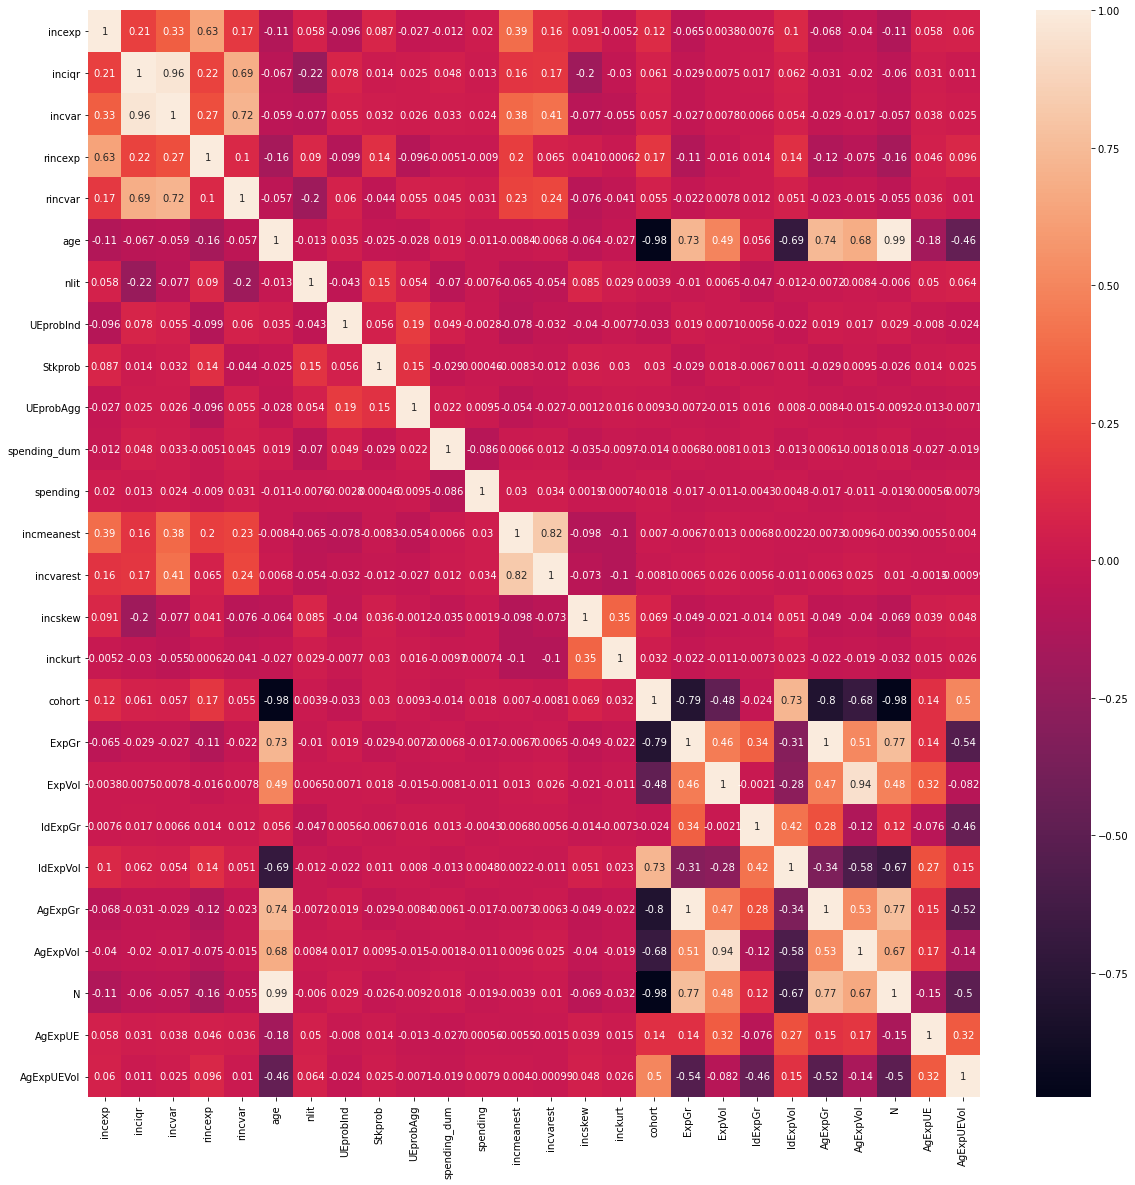

In [48]:
# correlation heatmap 
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(SCEM.corr(), annot = True)

###  3. Histograms

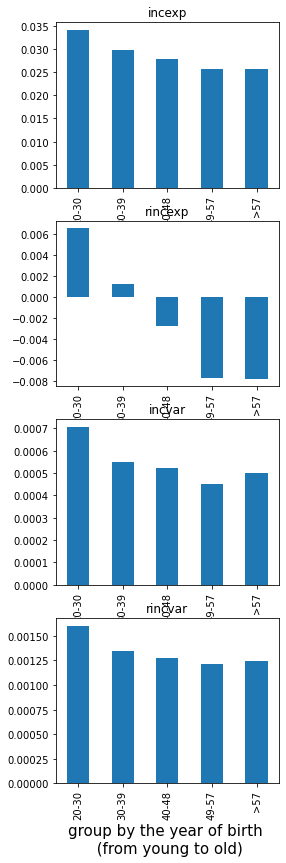

In [49]:
moms = ['incexp','rincexp','incvar','rincvar']


## by age 
fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('age_gr')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by the year of birth \n (from young to old)',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_age')

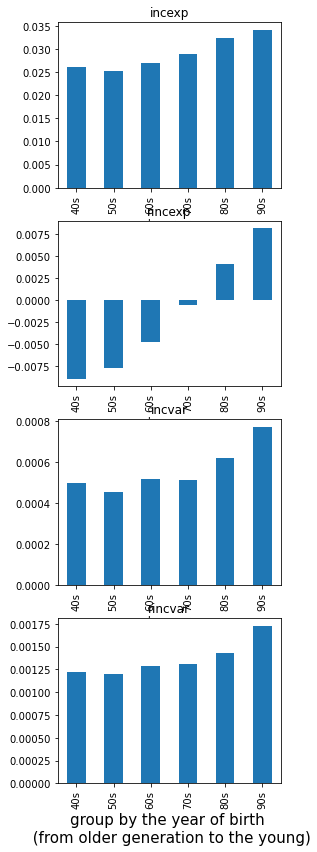

In [50]:
## by cohort 

fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('byear_gr')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by the year of birth \n (from older generation to the young)',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_cohort')

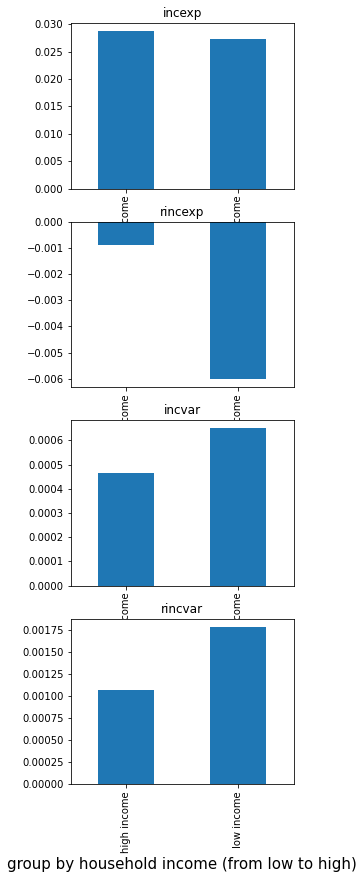

In [51]:
## by hh income 

fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('HHinc_gr')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by household income (from low to high)',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_inc')

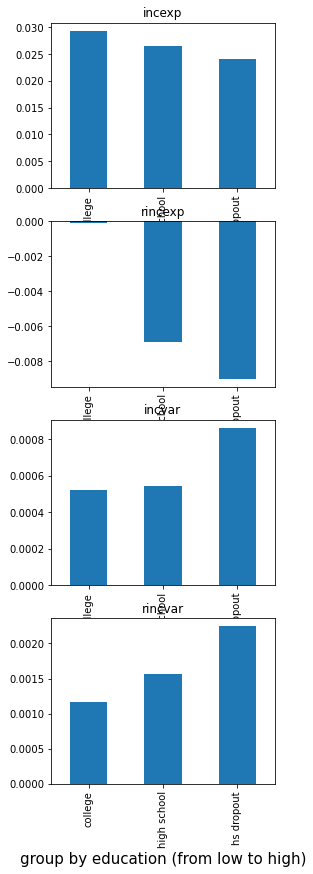

In [52]:
## by education

fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('educ_gr')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by education (from low to high)',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_educ')

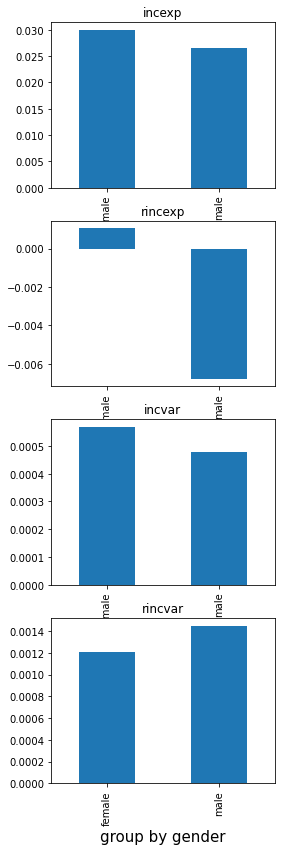

In [53]:
## by gender 

fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('gender')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by gender',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_gender')

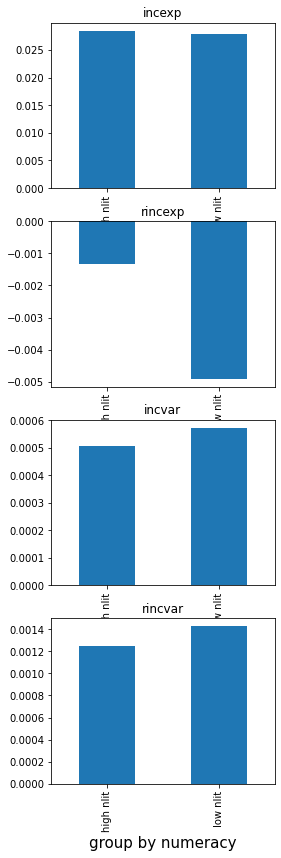

In [54]:
## by numeracy literacy  

fig,axes = plt.subplots(len(moms),figsize=(4,14))

for i,mom in enumerate(moms):
    #plt.style.use('ggplot')
    SCEM.groupby('nlit_gr')[mom].mean().plot(kind='bar', ax=axes[i],title=mom)
    #axes[i].set_ylabel(mom,size = 15)
    
    if i == len(moms)-1:
        axes[i].set_xlabel('group by numeracy',
              size = 15)
plt.savefig('../Graphs/ind/bar_by_nlit')

In [55]:
## by income group 

fontsize = 80
figsize = (100,50)

"""
for mom in ['incvar','rincvar']:
    for gp in ['HHinc','educ','gender']:
        plt.style.use('seaborn-poster')
        SCEM.boxplot(column=[mom],
                     figsize = figsize,
                     by = gp,
                     patch_artist = True,
                     fontsize = fontsize)
        plt.xlabel(gp,
                   fontsize = fontsize)
        plt.ylabel(mom,
                   fontsize = fontsize)
        plt.ylim(0,40)
        plt.suptitle('')
        plt.title(mom, fontsize= fontsize)
        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')
        
"""

"\nfor mom in ['incvar','rincvar']:\n    for gp in ['HHinc','educ','gender']:\n        plt.style.use('seaborn-poster')\n        SCEM.boxplot(column=[mom],\n                     figsize = figsize,\n                     by = gp,\n                     patch_artist = True,\n                     fontsize = fontsize)\n        plt.xlabel(gp,\n                   fontsize = fontsize)\n        plt.ylabel(mom,\n                   fontsize = fontsize)\n        plt.ylim(0,40)\n        plt.suptitle('')\n        plt.title(mom, fontsize= fontsize)\n        plt.savefig('../Graphs/ind/boxplot'+str(mom)+'_'+str(gp)+'.jpg')\n        \n"

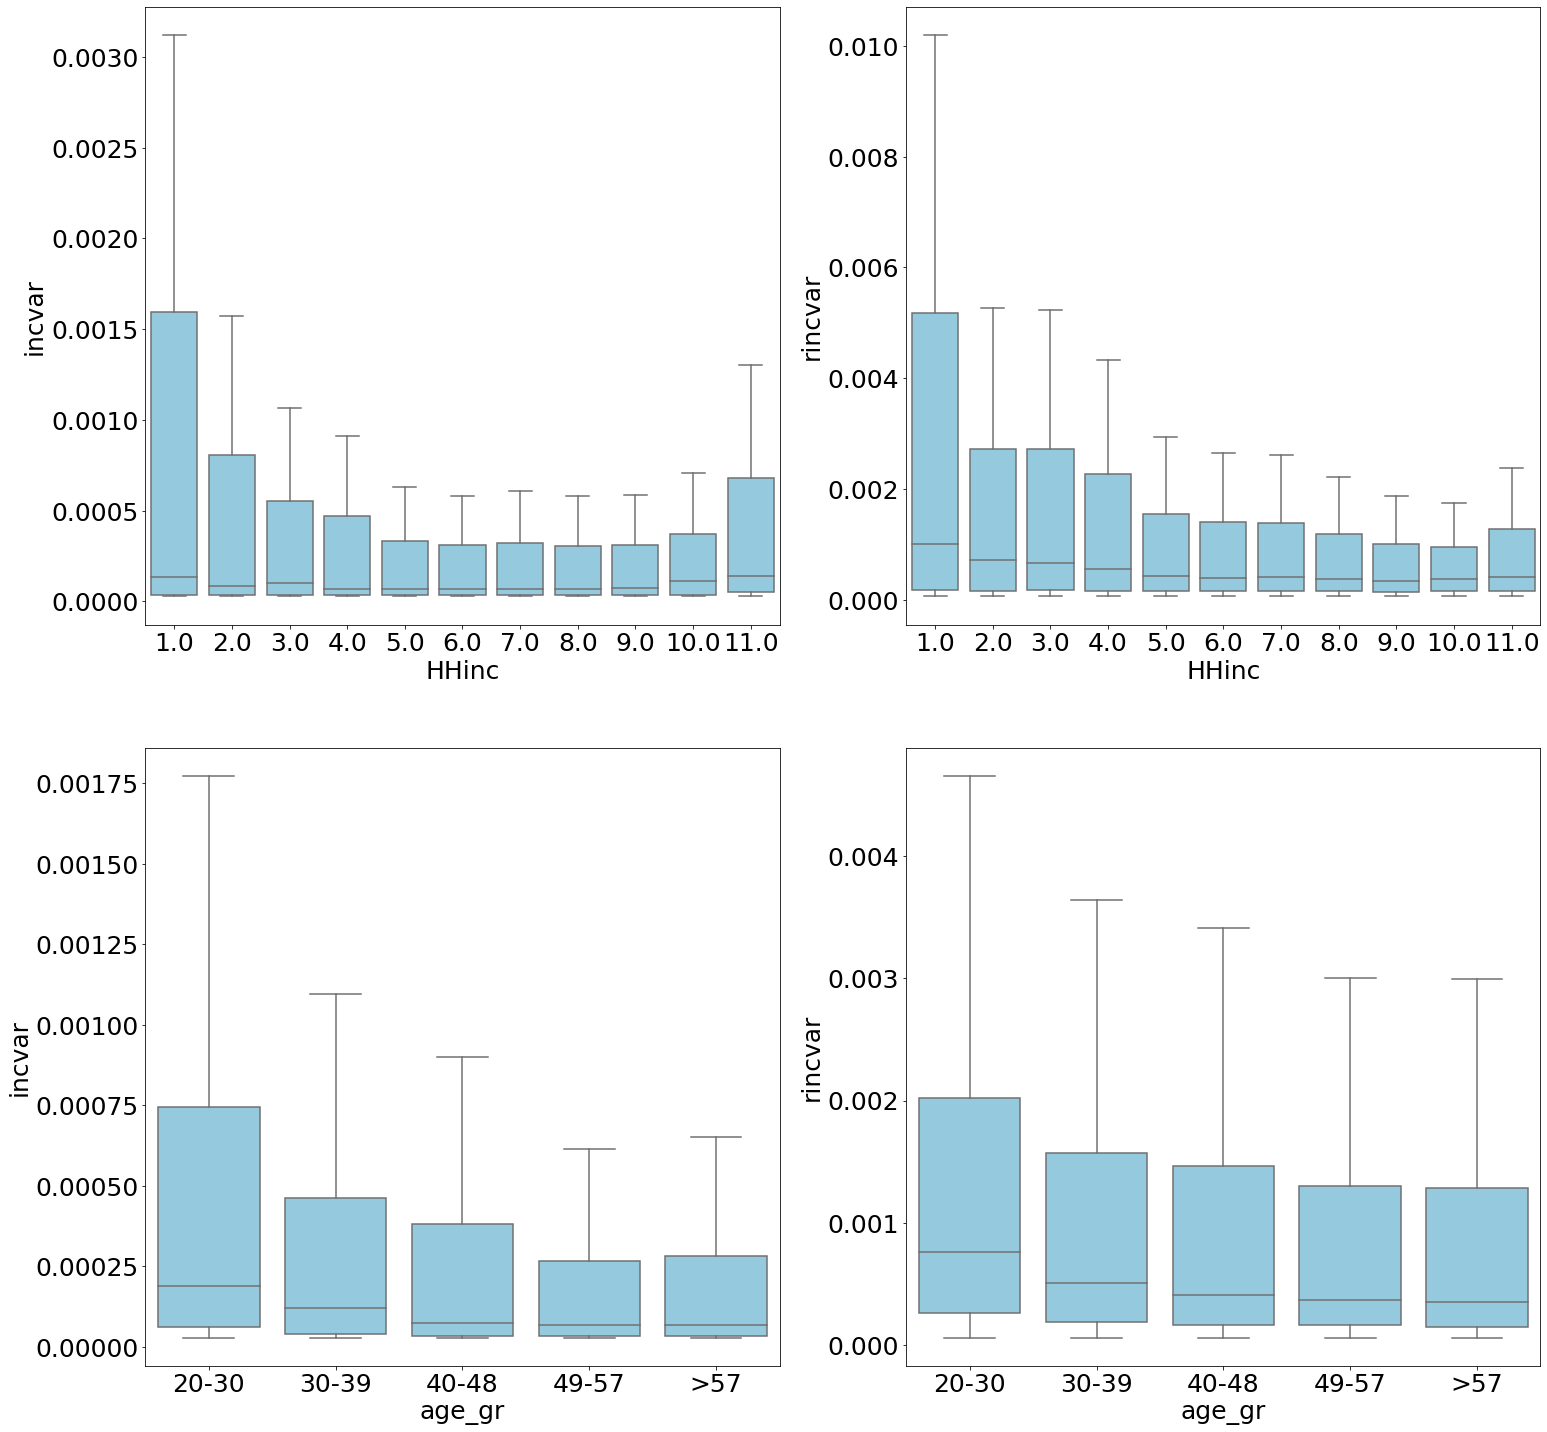

In [56]:
## variances by groups 

gplist = ['HHinc','age_gr']
momlist = ['incvar','rincvar']
incg_lb = list(inc_grp.values())


## plot 

fig,axes = plt.subplots(len(gplist),2,figsize =(25,25))

for i in range(len(gplist)):
    for j in range(2):
        gp = gplist[i]
        mom = momlist[j]
        if gplist[i] =='HHinc':
            bp = sns.boxplot(x = gp,
                            y = mom,
                            data = SCEM, 
                            color = 'skyblue',
                            ax = axes[i,j],
                            whis = True,
                            showfliers = False)
        else:
            bp = sns.boxplot(x = gp,
                             y = mom,
                             data = SCEM,
                             color = 'skyblue',
                             ax = axes[i,j],
                             showfliers = False)
            
        # settings 
        bp.set_xlabel(gp,fontsize = 25)
        bp.tick_params(labelsize = 25)
        bp.set_ylabel(mom,fontsize = 25)
        
plt.savefig('../Graphs/ind/boxplot.jpg')

### 4. Experienced volatility and risks

In [57]:
keeps = ['incexp','incvar','inciqr','rincexp','rincvar','incskew','ExpVol']

SCEM_cohort = pd.pivot_table(data = SCEM,
                             index=['year','age'],
                             values = keeps,
                             aggfunc= 'mean').reset_index().rename(columns={'incexp': 'expMean',
                                                                            'rincexp':'rexpMean',
                                                                            'incvar': 'varMean',
                                                                            'inciqr': 'iqrMean',
                                                                            'rincvar':'rvarMean',
                                                                            'incskew':'skewMean'})

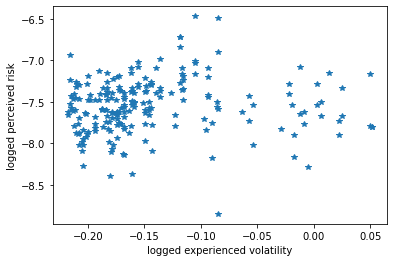

In [58]:
## scatter plot of experienced volatility and perceived risk 

plt.plot(figsize =(30,30))
plt.plot(np.log(SCEM_cohort['ExpVol']),
         np.log(SCEM_cohort['varMean']),
         '*',
         lw = 5)
plt.xlabel('logged experienced volatility')
plt.ylabel('logged perceived risk')

plt.savefig('../Graphs/ind/scatter_history_vol_var.jpg')

In [59]:
## generate logs 

vars_log = ['incvar','rincvar','inciqr','ExpVol','IdExpVol','AgExpVol','UEprobAgg','UEprobInd']

for var in vars_log:
    SCEM[var] = np.log(SCEM[var]+0.0000001)

In [69]:
## full-table for risks  

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

dep_list = ['incvar','inciqr'] 

for i,mom in enumerate(dep_list):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ ExpVol+ExpGr+ C(age_gr)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    model2 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+IdExpGr+ C(age_gr)+C(educ_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3
    model3 = smf.ols(formula = str(mom)
                    +'~ AgExpUEVol+AgExpUE+ C(age_gr) + C(HHinc_gr)+C(educ_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    
    ## model 4
    model4 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+IdExpGr+AgExpUEVol+AgExpUE+ C(age_gr) + C(HHinc_gr)+C(educ_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()

    
rs_names = [rs_list[i] for i in range(len(rs_list))]

dfoutput = summary_col(rs_names,
                        float_format='%0.2f',
                        stars = True,
                        regressor_order = ['ExpVol',
                                           'ExpGr',
                                           'IdExpVol',
                                           'IdExpGr',
                                           'AgExpUEVol',
                                           'AgExpUE',
                                           'C(age_gr)[T.30-39]',
                                           'C(age_gr)[T.40-48]',
                                           'C(age_gr)[T.49-57]',
                                           'C(age_gr)[T.>57]',
                                           'C(HHinc_gr)[T.low inc]'
                                          ],
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)}
                      )

dfoutput.title = 'Experienced Volatility and Perceived Income Risks'
print(dfoutput)

                              Experienced Volatility and Perceived Income Risks
                          incvar I incvar II incvar III incvar IIII inciqr I inciqr II inciqr III inciqr IIII
-------------------------------------------------------------------------------------------------------------
ExpVol                    0.08                                      -0.04                                    
                          (0.25)                                    (0.13)                                   
ExpGr                     2.33***                                   0.75***                                  
                          (0.52)                                    (0.29)                                   
IdExpVol                           2.50***              2.09***              1.25***              1.37***    
                                   (0.40)               (0.50)               (0.22)               (0.27)     
IdExpGr                            -15.4

In [61]:
## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=\\textwidth}
\\begin{threeparttable}
\\caption{Experienced Volatility and Perceived Income Risks}
\\label{micro_reg_history_vol}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by household. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\item This table reports regression results of perceived income risks on experienced volatility.
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""

## relabel rows 

def CatRename(table):
    relabels = {}
    rows = [idx for idx in table.index if ')[T.' in idx]
    for i in range(len(rows)):
        string = rows[i]
        var = string.split('C(')[1].split(')[T')[0]
        val = string.split('[T.')[1].split(']')[0]
        if '.0' in val:
            val = val.split('.0')[0]
        else:
            val = val 
        relabels[rows[i]] = var + '=' + str(val)
    table = table.rename(index = relabels)
    return table 

table = CatRename(dfoutput.tables[0])

## excluding rows that are not to be exported 

## drop the columns not wanted as well as rows below it 

def droptables(table,
              to_drop):
    table = table.reset_index()
    to_drop_ids = []

    for var in to_drop:
        to_drop_idx = table[table['index']==var].index[0]
        to_drop_ids.append(to_drop_idx)
        to_drop_ids.append(to_drop_idx+1)

    table = table.drop(index = to_drop_ids)
    table = table.set_index('index')
    table.index.name = ''
    return table

to_drop = ['Intercept','R-squared']
 
tb = droptables(table,
                to_drop)
"""
## write to latex 
f = open('../Tables/latex/micro_reg_history_vol.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()
"""
## save

tb.to_excel('../Tables/micro_reg_history_vol.xlsx')

###  5. Main regression

In [70]:
## preps 

dep_list =  ['incvar'] 
dep_list2 =['incexp','rincexp']
indep_list_ct = ['UEprobInd','UEprobAgg']
indep_list_dc = ['HHinc','selfemp','fulltime','nlit_gr']

In [88]:
## full-table for risks  

rs_list = {}  ## list to store results 
nb_spc = 6  ## number of specifications 

for i,mom in enumerate(dep_list):
    ## model 1 only with experienced volatility 
    model = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2 experienced vol and age 
    
    model2 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE+ age',
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 experienced vol, age, income, education 
    
    model3 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE+ age + C(gender)+ C(nlit_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 + job characteristics 
    
    model4 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE+ age+C(gender)+ C(nlit_gr)+C(educ_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
    ## model 5 + job characteristics 
    model5 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE+ age+C(parttime) + C(selfemp) + C(gender)+ C(HHinc_gr) + C(nlit_gr)+C(educ_gr)',
                    data = SCEM)
    rs_list[nb_spc*i+4] = model5.fit()
    
    
    ## model 6 + job characteristics 
    ct_str = '+'.join([var for var in indep_list_ct])
    model6 = smf.ols(formula = str(mom)
                    +'~ IdExpVol+AgExpVol+AgExpUE+age+C(parttime) + C(selfemp) + C(gender)+ C(HHinc_gr) + C(nlit_gr) +C(educ_gr)+'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+5] = model6.fit()
    
    
rs_names = [rs_list[i] for i in range(len(rs_list))]

dfoutput = summary_col(rs_names,
                        float_format='%0.2f',
                        stars = True,
                        regressor_order = [#'ExpVol',
                                           #'ExpGr',
                                           'IdExpVol',
                                           #'IdExpGr',
                                           'AgExpVol',
                                           #'AgExpGr',
                                           #'AgExpUEVol',
                                           'AgExpUE',
                                           'age',
                                           #'C(age_gr)[T.30-39]',
                                           #'C(age_gr)[T.40-48]',
                                           #'C(age_gr)[T.49-57]',
                                           #'C(age_gr)[T.>57]',
                                           'C(HHinc_gr)[T.low inc]',
                                           'C(gender)[T.male]',
                                           'C(nlit_gr)[T.low nlit]',
                                           'C(parttime)[T.yes]',
                                           'C(selfemp)[T.yes]',
                                           'UEprobAgg',
                                           'UEprobInd'],
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)
                                  })
dfoutput.title = 'Perceived Income Risks'
print(dfoutput)

                                    Perceived Income Risks
                          incvar I incvar II incvar III incvar IIII incvar IIIII incvar IIIIII
----------------------------------------------------------------------------------------------
IdExpVol                  4.58***  2.23***   2.69***    2.75***     2.95***      2.94***      
                          (0.33)   (0.36)    (0.39)     (0.39)      (0.38)       (0.39)       
AgExpVol                  0.04     0.28***   0.34***    0.32***     0.18***      0.20***      
                          (0.04)   (0.04)    (0.05)     (0.05)      (0.05)       (0.05)       
AgExpUE                   0.14***  0.08***   0.05**     0.05*       0.04*        0.05**       
                          (0.02)   (0.02)    (0.02)     (0.02)      (0.02)       (0.02)       
age                                -0.02***  -0.02***   -0.02***    -0.02***     -0.02***     
                                   (0.00)    (0.00)     (0.00)      (0.00)       (0.00

In [91]:
## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width=\\textwidth}
\\begin{threeparttable}
\\caption{Perceived Income Risks, Experienced Volatility and Individual Characteristics}
\\label{micro_reg}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by household. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\item This table reports results from a regression of looged perceived income risks (incvar) on logged indiosyncratic($\\text{IdExpVol}$), aggregate experienced volatility($\\text{AgExpVol}$), experienced unemployment rate (AgExpUE), and a list of household specific variables such as age, income, education, gender, job type and other economic expectations.
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""

## relabel rows 

def CatRename(table):
    relabels = {}
    rows = [idx for idx in table.index if ')[T.' in idx]
    for i in range(len(rows)):
        string = rows[i]
        var = string.split('C(')[1].split(')[T')[0]
        val = string.split('[T.')[1].split(']')[0]
        if '.0' in val:
            val = val.split('.0')[0]
        else:
            val = val 
        relabels[rows[i]] = var + '=' + str(val)
    table = table.rename(index = relabels)
    return table 
table = CatRename(dfoutput.tables[0])

## excluding rows that are not to be exported 

to_drop = ['Intercept','R-squared']
 
tb = droptables(table,
                to_drop)

## write to latex 
f = open('../Tables/latex/micro_reg.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()

## save
tb.to_excel('../Tables/micro_reg.xlsx')

In [92]:
tb

,incvar I,incvar II,incvar III,incvar IIII,incvar IIIII,incvar IIIIII
,,,,,,
IdExpVol,4.58***,2.23***,2.69***,2.75***,2.95***,2.94***
,(0.33),(0.36),(0.39),(0.39),(0.38),(0.39)
AgExpVol,0.04,0.28***,0.34***,0.32***,0.18***,0.20***
,(0.04),(0.04),(0.05),(0.05),(0.05),(0.05)
AgExpUE,0.14***,0.08***,0.05**,0.05*,0.04*,0.05**
,(0.02),(0.02),(0.02),(0.02),(0.02),(0.02)
age,,-0.02***,-0.02***,-0.02***,-0.02***,-0.02***
,,(0.00),(0.00),(0.00),(0.00),(0.00)
gender=male,,,-0.36***,-0.35***,-0.32***,-0.30***


In [38]:
## full-table for expected growth, appendix 

rs_list = {}  ## list to store results 
nb_spc = 4  ## number of specifications 

for i,mom in enumerate(dep_list2):
    ## model 1 
    model = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp)',
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    ## model 2
    ct_str = '+'.join([var for var in indep_list_ct])
    model2 = smf.ols(formula = str(mom)
                    +'~ C(parttime)+C(selfemp) + '
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+1] = model2.fit()
    
    ## model 3 
    model3 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(HHinc_gr) + C(educ_gr) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+2] = model3.fit()
    
    ## model 4 
    model4 = smf.ols(formula = str(mom)
                    +'~ C(parttime) + C(selfemp) + C(gender)+ C(educ_gr) + + C(HHinc_gr) +'
                     + ct_str,
                    data = SCEM)
    rs_list[nb_spc*i+3] = model4.fit()
    
    
rs_names = [rs_list[i] for i in range(len(rs_list))]

dfoutput2 = summary_col(rs_names,
                        float_format='%0.2f',
                        stars = True,
                        regressor_order = ['C(parttime)[T.yes]',
                                           'C(selfemp)[T.yes]',
                                           'UEprobAgg','UEprobInd',
                                           'C(HHinc_gr)[T.low inc]',
                                           'C(educ_gr)[T.low educ]',
                                           'C(gender)[T.male]'
                                           ],
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)
                                  })

dfoutput2.title = 'Perceived Income Growth'
print(dfoutput2)

## relabel 
table = CatRename(dfoutput2.tables[0])

## excluding rows that are not to be exported 

to_drop = ['Intercept','R-squared']
 
tb = droptables(table,
                to_drop)

## latex setting 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width={\\textwidth}}
\\begin{threeparttable}
\\caption{Perceived Income Growth and Individual Characteristics}
\\label{micro_reg_exp}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by household. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\item This table reports regression results of perceived labor income(incexp for nominal, rincexp for real) growth on household specific variables. HHinc: household income group ranges from lowests (=1, less than \$10k/year) to the heightst (=11, greater than \$200k/year). Education, educ ranges from the lowest (=1, less than high school) to the highest (=9).
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""

"""
## write to latex 
f = open('../Tables/latex/micro_reg_exp.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()
"""

                                           Perceived Income Growth
                       incexp I incexp II incexp III incexp IIII rincexp I rincexp II rincexp III rincexp IIII
--------------------------------------------------------------------------------------------------------------
C(parttime)[T.yes]     -0.42*** -0.39***  -0.37***   -0.33***    -0.56***  -0.56***   -0.44***    -0.33***    
                       (0.03)   (0.03)    (0.03)     (0.03)      (0.04)    (0.04)     (0.04)      (0.05)      
C(selfemp)[T.yes]      0.86***  -0.00***  0.00***    -0.00**     0.83***   0.00***    0.00        -0.00***    
                       (0.04)   (0.00)    (0.00)     (0.00)      (0.05)    (0.00)     (0.00)      (0.00)      
UEprobAgg                       -0.01     -0.01      -0.02**               -0.11***   -0.11***    -0.11***    
                                (0.01)    (0.01)     (0.01)                (0.01)     (0.01)      (0.01)      
UEprobInd                       -0.03***  -0.

"\n## write to latex \nf = open('../Tables/latex/micro_reg_exp.tex', 'w')\nf.write(beginningtex)\ntb_ltx = tb.to_latex().replace('lllllllll','ccccccccc')   # hard coded here \n#print(tb)\nf.write(tb_ltx)\nf.write(endtex)\nf.close()\n"

## 5. Perceived risks and decisions



In [40]:
## full-table for risks  

rs_list = {}  ## list to store results 
nb_spc = 1  ## number of specifications 

dep_list3 = ['incexp','incvar','rincvar','incskew','UEprobAgg']


for i,mom in enumerate(dep_list3):
    ## model 1 
    model = smf.ols(formula = 'spending'+ '~'+ mom,
                    data = SCEM)
    rs_list[nb_spc*i] = model.fit()
    
    
rs_names = [rs_list[i] for i in range(len(rs_list))]

dfoutput = summary_col(rs_names,
                        float_format='%0.2f',
                        stars = True,
                        regressor_order = ['incexp',
                                           'incvar',
                                           'rincvar',
                                           'incskew',
                                          'UEprobAgg'],
                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared)})
dfoutput.title = 'Perceived Income Risks and Household Spending'
print(dfoutput)

              Perceived Income Risks and Household Spending
          spending I spending II spending III spending IIII spending IIIII
--------------------------------------------------------------------------
incexp    39.11***                                                        
          (8.47)                                                          
incvar               1.86***                                              
                     (0.46)                                               
rincvar                          2.49***                                  
                                 (0.35)                                   
incskew                                       0.19                        
                                              (0.45)                      
UEprobAgg                                                   0.44*         
                                                            (0.25)        
Intercept 3.46***    16.97***    20.25**

In [41]:
## output tables 

beginningtex = """
\\begin{table}[p]
\\centering
\\begin{adjustbox}{width={0.9\\textwidth}}
\\begin{threeparttable}
\\caption{Perceived Income Risks and Household Spending}
\\label{spending_reg}"""

endtex = """\\begin{tablenotes}\item Standard errors are clustered by household. *** p$<$0.001, ** p$<$0.01 and * p$<$0.05. 
\item This table reports regression results of expected spending growth on perceived income risks (incvar for nominal, rincvar for real).
\\end{tablenotes}
\\end{threeparttable}
\\end{adjustbox}
\\end{table}"""


## relabel rows 

def CatRename(table):
    relabels = {}
    rows = [idx for idx in table.index if ')[T.' in idx]
    for i in range(len(rows)):
        string = rows[i]
        var = string.split('C(')[1].split(')[T')[0]
        val = string.split('[T.')[1].split(']')[0]
        if '.0' in val:
            val = val.split('.0')[0]
        else:
            val = val 
        relabels[rows[i]] = var + '=' + str(val)
    table = table.rename(index = relabels)
    return table 
table = CatRename(dfoutput.tables[0])

## excluding rows that are not to be exported 

to_drop = ['Intercept','R-squared']
 
tb = droptables(table,
                to_drop)

## excel version 
tb.to_excel('../Tables/spending_reg.xlsx')

## write to latex 
f = open('../Tables/latex/spending_reg.tex', 'w')
f.write(beginningtex)
tb_ltx = tb.to_latex().replace('llllll','cccccc')   # hard coded here 
#print(tb)
f.write(tb_ltx)
f.write(endtex)
f.close()